In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.neural_network import MLPRegressor

In [2]:
# Aggregate all football-data.co.uk data to the same csv
df = pd.read_csv('data/football-data/agg-football-data.csv', low_memory=False, date_parser=['Date'])
df['HomeTeam'] = df['HomeTeam'].str.strip()
df['AwayTeam'] = df['AwayTeam'].str.strip()
df['gameName'] = df['HomeTeam'] + ' - ' + df['AwayTeam']
df['Date'] = pd.to_datetime(df['Date'])
df['delta_ft'] = df['FTHG'] - df['FTAG']
df = df.iloc[:-300] # removing last 300 games for testing
df.sample(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBAHA,LBAH,B365AH,LB,LB.1,LB.2,HFKC,AFKC,gameName,delta_ft
105187,SP1,2010-04-17,Espanol,Barcelona,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Espanol - Barcelona,0.0
87334,F1,2008-01-12,Le Mans,Sochaux,0.0,2.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Le Mans - Sochaux,-2.0
121639,P1,2012-09-01,Olhanense,Porto,2.0,3.0,A,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Olhanense - Porto,-1.0
39576,B1,2001-04-22,Aalst,Westerlo,1.0,2.0,A,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aalst - Westerlo,-1.0
109310,F1,2010-12-18,St Etienne,Arles,2.0,0.0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,St Etienne - Arles,2.0


In [3]:
# Math to justify why forecasting 1-1 is so good
(df.FTHG <= 2).sum()/len(df), (df.FTAG <= 2).sum()/len(df)

(0.8089696267400567, 0.8887662392799525)

In [4]:
# define a function to calculate the elo rating
def update_elo(home_elo, away_elo, home_outcome, away_outcome, k=32, a=400):
    # calculate the expected score
    home_expected = 1 / (1 + 10 ** ((away_elo - home_elo) / a))
    away_expected = 1 / (1 + 10 ** ((home_elo - away_elo) / a))
    
    # calculate the new elo
    home_elo = home_elo + k * (home_outcome - home_expected)
    away_elo = away_elo + k * (away_outcome - away_expected)
    
    return home_elo, away_elo

In [5]:
def get_team_elo(team, elo_dict):
    if team in elo_dict.keys():
        return elo_dict[team]
    else:
        return 500

In [6]:
elo_dict = {}
game_home_elo, game_away_elo = [], []
for i, game in tqdm(df.iterrows(), total=df.shape[0]):
    home = game['HomeTeam']
    away = game['AwayTeam']
    home_goals = game['FTHG']
    away_goals = game['FTAG']

    home_elo = get_team_elo(home, elo_dict)
    away_elo = get_team_elo(away, elo_dict)
    game_home_elo.append(home_elo)
    game_away_elo.append(away_elo)

    home_outcome = (home_goals > away_goals) * 1 + (home_goals == away_goals) * 0.5
    away_outcome = (away_goals > home_goals) * 1 + (away_goals == home_goals) * 0.5
    
    home_elo, away_elo = update_elo(home_elo, away_elo, home_outcome, away_outcome)
    
    elo_dict[home] = home_elo
    elo_dict[away] = away_elo

100%|██████████| 200209/200209 [00:28<00:00, 7115.50it/s]


In [7]:
df['home_elo'] = game_home_elo
df['away_elo'] = game_away_elo
df['delta_elo'] = df['home_elo'] - df['away_elo']
df['home_xg_shot'] = df['FTHG'] / df['HS'].clip(lower=1)
df['away_xg_shot'] = df['FTAG'] / df['AS'].clip(lower=1)

# Shot estimation model

## KNN

    _df = df[['Date', 'HomeTeam', 'AwayTeam', 'home_elo', 'away_elo', 'delta_elo', 'FTHG', 'FTAG', 'delta_ft', 'HS', 'AS', 'home_xg_shot', 'away_xg_shot']].dropna().copy()
    model_shots = NearestNeighbors(n_neighbors=50, n_jobs=-1)
    model_shots.fit(_df[['home_elo', 'away_elo']])

    grid = pd.DataFrame(np.array([[x, y] for x in range(0, 1200, 5) for y in range(0, 1200, 5)]), columns=['home_elo', 'away_elo'])
    distances, indices = model_shots.kneighbors(grid[['home_elo', 'away_elo']])

    pred, std = [], []
    for i in tqdm(range(grid.shape[0]), total=grid.shape[0]):
        pred.append(_df.iloc[indices[i]]['HS'].mean())
        std.append(_df.iloc[indices[i]]['HS'].std())

    grid['pred'] = pred
    grid['std'] = std

    plt.rcParams['figure.figsize'] = (16, 6)
    plt.subplot(1, 2, 1)
    plt.scatter(grid['home_elo'], grid['away_elo'], c=grid['pred'], cmap='viridis', s=1);
    plt.title('Home Shots')
    plt.xlabel('Home ELO');
    plt.ylabel('Away ELO');
    plt.colorbar();
    plt.subplot(1, 2, 2)
    plt.scatter(grid['home_elo'], grid['away_elo'], c=grid['std'], cmap='viridis', s=1);
    plt.title('Home Shots Variance')
    plt.xlabel('Home ELO');
    plt.ylabel('Away ELO');
    plt.colorbar();

## Regression

In [10]:
_df = df[['Date', 'HomeTeam', 'AwayTeam', 'home_elo', 'away_elo', 'delta_elo', 'FTHG', 'FTAG', 'delta_ft', 'HS', 'AS', 'home_xg_shot', 'away_xg_shot']].dropna().copy()

model_shots_LR = {}
model_shots_LR['HS'] = LinearRegression()
model_shots_LR['AS'] = LinearRegression()
model_shots_LR['home_xg_shot'] = LinearRegression()
model_shots_LR['away_xg_shot'] = LinearRegression()

for key in list(model_shots_LR.keys()):
    model_shots_LR[key].fit(_df[['home_elo', 'away_elo']], _df[key])

    _df['pred'] = model_shots_LR[key].predict(_df[['home_elo', 'away_elo']])
    _df['error'] = abs(_df['pred'] - _df[key])

    model_shots_LR['error_' + key] = LinearRegression() 
    model_shots_LR['error_' + key].fit(_df[['home_elo', 'away_elo']], _df['error'])

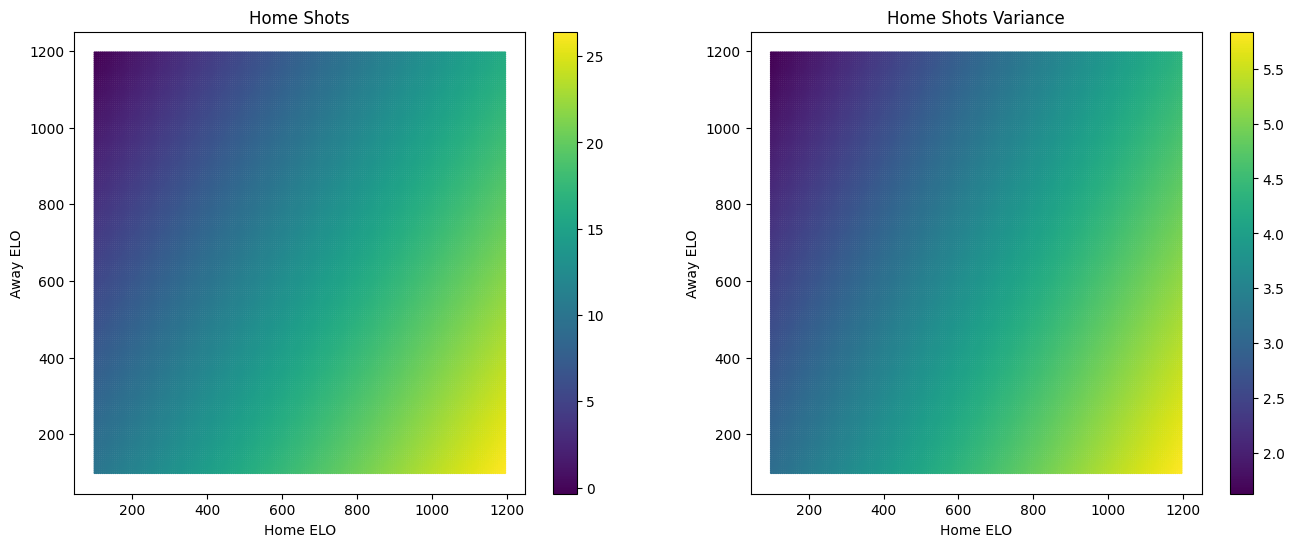

In [11]:
grid = pd.DataFrame(np.array([[x, y] for x in range(100, 1200, 5) for y in range(100, 1200, 5)]), columns=['home_elo', 'away_elo'])
grid['pred'] = model_shots_LR['HS'].predict(grid[['home_elo', 'away_elo']])
grid['std'] = model_shots_LR['error_HS'].predict(grid[['home_elo', 'away_elo']])

plt.rcParams['figure.figsize'] = (16, 6)
plt.subplot(1, 2, 1)
plt.scatter(grid['home_elo'], grid['away_elo'], c=grid['pred'], cmap='viridis', s=1);
plt.title('Home Shots')
plt.xlabel('Home ELO');
plt.ylabel('Away ELO');
plt.colorbar();
plt.subplot(1, 2, 2)
plt.scatter(grid['home_elo'], grid['away_elo'], c=grid['std'], cmap='viridis', s=1);
plt.title('Home Shots Variance')
plt.xlabel('Home ELO');
plt.ylabel('Away ELO');
plt.colorbar();

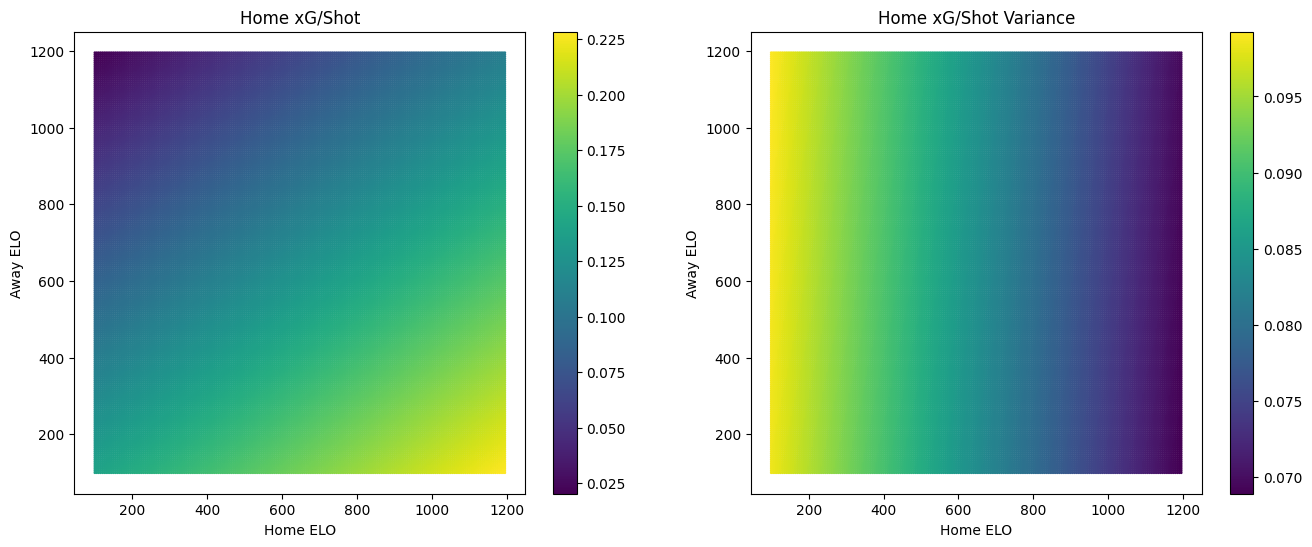

In [12]:
grid = pd.DataFrame(np.array([[x, y] for x in range(100, 1200, 5) for y in range(100, 1200, 5)]), columns=['home_elo', 'away_elo'])
grid['pred'] = model_shots_LR['home_xg_shot'].predict(grid[['home_elo', 'away_elo']])
grid['std'] = model_shots_LR['error_home_xg_shot'].predict(grid[['home_elo', 'away_elo']])

plt.rcParams['figure.figsize'] = (16, 6)
plt.subplot(1, 2, 1)
plt.scatter(grid['home_elo'], grid['away_elo'], c=grid['pred'], cmap='viridis', s=1);
plt.title('Home xG/Shot')
plt.xlabel('Home ELO');
plt.ylabel('Away ELO');
plt.colorbar();
plt.subplot(1, 2, 2)
plt.scatter(grid['home_elo'], grid['away_elo'], c=grid['std'], cmap='viridis', s=1);
plt.title('Home xG/Shot Variance')
plt.xlabel('Home ELO');
plt.ylabel('Away ELO');
plt.colorbar();

In [13]:
model_shots = model_shots_LR

# Prediction Pipeline

In [14]:
def get_team_elo_series(df, team):
    return pd.concat([df[df.HomeTeam == team].set_index('Date')['home_elo'].rename('elo'), df[df.AwayTeam == team].set_index('Date')['away_elo'].rename('elo')]).sort_index()

In [15]:
import sklearn

def generate_sample(pred, std, n_samples=1000):
    sample = []
    for _ in range(n_samples):
        sample += (max(0, np.random.choice(pred)) + np.random.normal(0, np.random.choice(std), 100)).tolist()
    sample = np.array(sample)
    sample = sample[sample >= 0]
    return sample

def get_elo_estimate(df, team):
    team_series = get_team_elo_series(df, team)
    if len(team_series) == 0:
        print(team)
        return np.NaN, np.NaN
    team_mean, team_std = team_series.rolling(10, min_periods=1).mean().iloc[-1], team_series.rolling(10, min_periods=1).std().iloc[-1]
    return team_mean, team_std

def get_shot_samples(model_shots, home_mean, home_std, away_mean, away_std, grid_samples=100, n_samples=100):
    _grid = pd.DataFrame(np.array([np.random.normal(home_mean, home_std, grid_samples), np.random.normal(away_mean, away_std, grid_samples)]).T, columns=['home_elo', 'away_elo'])
    estimates = {
        'home': {'shot': {'mean':[], 'std': []}, 'xg':{'mean':[], 'std': []}},
        'away': {'shot': {'mean':[], 'std': []}, 'xg':{'mean':[], 'std': []}},
    }

    if type(model_shots) == sklearn.neighbors._unsupervised.NearestNeighbors:
        _, indices = model_shots.kneighbors(_grid[['home_elo', 'away_elo']])

        for i in range(_grid.shape[0]):
            neighbors = _df.iloc[indices[i]]
            estimates['home']['shot']['mean'].append(neighbors['HS'].mean())
            estimates['home']['shot']['std'].append(neighbors['HS'].std())
            estimates['away']['shot']['mean'].append(neighbors['AS'].mean())
            estimates['away']['shot']['std'].append(neighbors['AS'].std())
            estimates['home']['xg']['mean'].append(neighbors['home_xg_shot'].mean())
            estimates['home']['xg']['std'].append(neighbors['home_xg_shot'].std())
            estimates['away']['xg']['mean'].append(neighbors['away_xg_shot'].mean())
            estimates['away']['xg']['std'].append(neighbors['away_xg_shot'].std())
    elif type(model_shots) == dict:
        estimates['home']['shot']['mean'] = model_shots['HS'].predict(_grid[['home_elo', 'away_elo']]).tolist()
        estimates['home']['shot']['std'] = model_shots['error_HS'].predict(_grid[['home_elo', 'away_elo']]).tolist()
        estimates['away']['shot']['mean'] = model_shots['AS'].predict(_grid[['home_elo', 'away_elo']]).tolist()
        estimates['away']['shot']['std'] = model_shots['error_AS'].predict(_grid[['home_elo', 'away_elo']]).tolist()
        estimates['home']['xg']['mean'] = model_shots['home_xg_shot'].predict(_grid[['home_elo', 'away_elo']]).tolist()
        estimates['home']['xg']['std'] = model_shots['error_home_xg_shot'].predict(_grid[['home_elo', 'away_elo']]).tolist()
        estimates['away']['xg']['mean'] = model_shots['away_xg_shot'].predict(_grid[['home_elo', 'away_elo']]).tolist()
        estimates['away']['xg']['std'] = model_shots['error_away_xg_shot'].predict(_grid[['home_elo', 'away_elo']]).tolist()


    home_shot_sample = generate_sample(estimates['home']['shot']['mean'], estimates['home']['shot']['std'], n_samples=n_samples)
    away_shot_sample = generate_sample(estimates['away']['shot']['mean'], estimates['away']['shot']['std'], n_samples=n_samples)
    home_xg_sample = generate_sample(estimates['home']['xg']['mean'], estimates['home']['xg']['std'], n_samples=n_samples)
    away_xg_sample = generate_sample(estimates['away']['xg']['mean'], estimates['away']['xg']['std'], n_samples=n_samples)

    return home_shot_sample, away_shot_sample, home_xg_sample, away_xg_sample

def predict_odds(home_shot_sample, away_shot_sample, home_xg_sample, away_xg_sample, n_samples=1000):
    results = {'home':[], 'away':[]}

    home_shots = np.random.choice(home_shot_sample, size=n_samples)
    away_shots = np.random.choice(away_shot_sample, size=n_samples)
    for h_shot_pred, a_shot_pred in zip(home_shots, away_shots):
        h_shot_pred, a_shot_pred = int(h_shot_pred), int(a_shot_pred) # ROUND TODO
        home_goals = np.sum(np.random.choice(home_xg_sample, size=h_shot_pred) > np.random.uniform(0, 1, h_shot_pred)).sum()
        away_goals = np.sum(np.random.choice(away_xg_sample, size=a_shot_pred) > np.random.uniform(0, 1, a_shot_pred)).sum()

        results['home'].append(home_goals)
        results['away'].append(away_goals)

    results = pd.DataFrame(results)
    print(f'Home Wins  : {(results.home > results.away).sum() / len(results)}')
    print(f'Draws      : {(results.home == results.away).sum() / len(results)}')
    print(f'Away Wins  : {(results.home < results.away).sum() / len(results)}')
    print(f'Home Score : {results.home.mean()}')
    print(f'Away Score : {results.away.mean()}')

def predict_odds_compact(df, model_shots, home_team, away_team):
    home_mean, home_std = get_elo_estimate(df, home_team)
    away_mean, away_std = get_elo_estimate(df, away_team)

    home_shot_sample, away_shot_sample, home_xg_sample, away_xg_sample = get_shot_samples(model_shots, home_mean, home_std, away_mean, away_std, grid_samples=100, n_samples=2000)
    print(f'{home_team} vs {away_team}')
    predict_odds(home_shot_sample, away_shot_sample, home_xg_sample, away_xg_sample, n_samples=1000)
    print()

In [16]:
predict_odds_compact(_df, model_shots, 'Porto', 'Benfica')
predict_odds_compact(_df, model_shots, 'Maritimo', 'Casa Pia')
predict_odds_compact(_df, model_shots, 'Rio Ave', 'Portimonense')

Porto vs Benfica
Home Wins  : 0.501
Draws      : 0.23
Away Wins  : 0.269
Home Score : 1.833
Away Score : 1.28

Maritimo vs Casa Pia
Home Wins  : 0.369
Draws      : 0.263
Away Wins  : 0.368
Home Score : 1.468
Away Score : 1.518

Rio Ave vs Portimonense
Home Wins  : 0.489
Draws      : 0.233
Away Wins  : 0.278
Home Score : 1.74
Away Score : 1.281



# Challenge data

In [17]:
df_train = pd.read_excel('data/challenge/TrainingSet-FINAL.xlsx')
df_train = df_train[df_train['HS'] != -1]
df_train = df_train.rename(columns={'HT': 'HomeTeam', 'AT': 'AwayTeam'})
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d/%m/%Y')
df_train['HomeTeam'] = df_train['Lge'].str[:-1] + '_' + df_train['HomeTeam']
df_train['AwayTeam'] = df_train['Lge'].str[:-1] + '_' + df_train['AwayTeam']
df_train = df_train.sort_values('Date')

In [18]:
df_test = pd.read_excel('data/challenge/PredictionSet-FINAL.xlsx')
df_test = df_test.rename(columns={'HT': 'HomeTeam', 'AT': 'AwayTeam'})
df_test['HomeTeam'] = df_test['Lge'].str[:-1] + '_' + df_test['HomeTeam']
df_test['AwayTeam'] = df_test['Lge'].str[:-1] + '_' + df_test['AwayTeam']

In [19]:
elo_dict = {}
game_home_elo, game_away_elo = [], []
for i, game in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    home = game['HomeTeam']
    away = game['AwayTeam']
    home_goals = game['HS']
    away_goals = game['AS']

    home_elo = get_team_elo(home, elo_dict)
    away_elo = get_team_elo(away, elo_dict)

    game_home_elo.append(home_elo)
    game_away_elo.append(away_elo)
    
    home_outcome = (home_goals > away_goals) * 1 + (home_goals == away_goals) * 0.5
    away_outcome = (away_goals > home_goals) * 1 + (away_goals == home_goals) * 0.5
    
    home_elo, away_elo = update_elo(home_elo, away_elo, home_outcome, away_outcome)
    
    elo_dict[home] = home_elo
    elo_dict[away] = away_elo

100%|██████████| 302691/302691 [00:36<00:00, 8282.58it/s]


In [20]:
df_train['home_elo'] = game_home_elo
df_train['away_elo'] = game_away_elo

In [21]:
df_val = df_train.iloc[-300:]
df_train_val = df_train.iloc[:-300]

In [22]:
def predict_odds_challenge(home_shot_sample, away_shot_sample, home_xg_sample, away_xg_sample, n_samples=1000):
    results = {'home':[], 'away':[]}

    home_shots = np.random.choice(home_shot_sample, size=n_samples)
    away_shots = np.random.choice(away_shot_sample, size=n_samples)
    for h_shot_pred, a_shot_pred in zip(home_shots, away_shots):
        h_shot_pred, a_shot_pred = int(h_shot_pred)+1, int(a_shot_pred)+1
        home_goals = np.sum(np.random.choice(home_xg_sample, size=h_shot_pred) > np.random.uniform(0, 1, h_shot_pred)).sum()
        away_goals = np.sum(np.random.choice(away_xg_sample, size=a_shot_pred) > np.random.uniform(0, 1, a_shot_pred)).sum()

        results['home'].append(home_goals)
        results['away'].append(away_goals)

    results = pd.DataFrame(results)

    return {
            'H_odd': (results.home > results.away).sum() / len(results),
            'D_odd': (results.home == results.away).sum() / len(results),
            'A_odd': (results.home < results.away).sum() / len(results),
            'H_mean_score': results.home.mean(),
            'A_mean_score': results.away.mean(),
            'H_median_score': results.home.median(),
            'A_median_score': results.away.median(),
            'H_proj_score': results.home.value_counts().index[0],
            'A_proj_score': results.away.value_counts().index[0]
        }

def wrapper_predict_odds_challenge(df, model_shots, home_team, away_team):
    home_mean, home_std = get_elo_estimate(df, home_team)
    away_mean, away_std = get_elo_estimate(df, away_team)

    if any([np.isnan(i) for i in [home_mean, home_std, away_mean, away_std]]):
        return {}

    home_shot_sample, away_shot_sample, home_xg_sample, away_xg_sample = get_shot_samples(model_shots, home_mean, home_std, away_mean, away_std, grid_samples=100, n_samples=2000)
    return {**predict_odds_challenge(home_shot_sample, away_shot_sample, home_xg_sample, away_xg_sample, n_samples=1000), **{'H_ELO': home_mean, 'A_ELO': away_mean}}

# Evaluating the model

In [23]:
results = []
for i, row in tqdm(df_val.iterrows(), total=df_val.shape[0]):
    res = wrapper_predict_odds_challenge(df_train_val, model_shots, row['HomeTeam'], row['AwayTeam'])
    res['HomeTeam'] = row['HomeTeam']
    res['AwayTeam'] = row['AwayTeam']
    res['HS'] = row['HS']
    res['AS'] = row['AS']
    res['Date'] = row['Date']

    results.append(res)  

100%|██████████| 300/300 [03:23<00:00,  1.47it/s]


In [24]:
val_results = pd.DataFrame(results)
val_results['res_h'] = val_results.HS > val_results.AS
val_results['res_d'] = val_results.HS == val_results.AS
val_results['res_a'] = val_results.HS < val_results.AS
val_results['outcome'] = 'H_odd'
val_results.loc[val_results.res_d, 'outcome'] = 'D_odd'
val_results.loc[val_results.res_a, 'outcome'] = 'A_odd'
val_results = val_results.dropna()

In [25]:
def rps(predictions, observed):
    """Vectorized version of Ranked Probability Score.
    A lower value is a better score.
    From: Colin Catlin, https://syllepsis.live/2022/01/22/ranked-probability-score-in-python/

    Args:
        predictions (pd.DataFrame): each column is an outcome category
            with values as the 0 to 1 probability of that category
        observed (pd.DataFrame): each column is an outcome category
            with values of 0 OR 1 with 1 being that category occurred
    """
    assert (
        predictions.shape == observed.shape
    ), "prediction and observed array shapes must match"
    ncat = predictions.shape[1] - 1
    return (
        np.sum(
            (np.cumsum(predictions, axis=1) - np.cumsum(observed, axis=1)) ** 2, axis=1
        ) / ncat
    )

predictions = val_results[['H_odd', 'D_odd', 'A_odd']]
observed = pd.get_dummies(val_results["outcome"]).reindex(
    columns=predictions.columns, fill_value=0
)
rps_result = rps(predictions, observed)

print(rps_result.mean().round(6))

0.21559


In [26]:
predictions = val_results[['H_odd', 'D_odd', 'A_odd']].copy()

predictions['D_odd'] = predictions['D_odd'] * 1.4
predictions[['D_odd', 'H_odd', 'A_odd']] = predictions[['D_odd', 'H_odd', 'A_odd']].div(predictions.sum(axis=1), axis=0)

observed = pd.get_dummies(val_results["outcome"]).reindex(columns=predictions.columns, fill_value=0)
rps(predictions, observed).mean().round(6)

0.215236

### Best result: 0.21607 w/KNN

In [27]:
# RMSE
np.sqrt((((val_results.H_proj_score - val_results.HS) ** 2) + ((val_results.A_proj_score - val_results.AS) ** 2)).sum() / len(val_results))

1.7691806012954132

In [28]:
# RMSE - random baseline
np.sqrt((((np.random.uniform(0, 3, len(val_results)).round() - val_results.HS) ** 2) + ((np.random.uniform(0, 3, len(val_results)).round() - val_results.AS) ** 2)).sum() / len(val_results))

2.2375581929117883

# Deploy

In [29]:
results = []
for i, row in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    res = wrapper_predict_odds_challenge(df_train, model_shots, row['HomeTeam'], row['AwayTeam'])
    res['HT'] = row['HomeTeam']
    res['AT'] = row['AwayTeam']
    res['Date'] = row['Date']
    res['Lge'] = row['Lge']
    res['Sea'] = row['Sea']
    res['ID'] = row['ID']
    

    results.append(res)  

100%|██████████| 736/736 [1:21:10<00:00,  6.62s/it]     


In [30]:
results = pd.DataFrame(results)
results['total_goals_pred'] = results['H_proj_score'] + results['A_proj_score']
results.to_csv('data/challenge/final_predictions.csv', index=False)

In [31]:
results['HT'] = results['HT'].str.split('_').str[1]
results['AT'] = results['AT'].str.split('_').str[1]

In [32]:
results['prd_HS'] = results['H_proj_score']
results['prd_AS'] = results['A_proj_score']
results['prd_W'] = results['H_odd']
results['prd_D'] = results['D_odd']
results['prd_L'] = results['A_odd']
results['WDL'] = 'D'
results['HS'] = -1
results['AS'] = -1
results['GD'] = 0
results[['ID', 'Sea', 'Lge', 'Date', 'HT', 'AT', 'HS', 'AS', 'GD', 'WDL', 'prd_HS', 'prd_AS', 'prd_W', 'prd_D', 'prd_L']].to_csv('data/challenge/PredictionSet-Team-ProDEI-FEUP.csv', index=False)

In [33]:
results.sample(20)

,H_odd,D_odd,A_odd,H_mean_score,A_mean_score,H_median_score,A_median_score,H_proj_score,A_proj_score,H_ELO,...,total_goals_pred,prd_HS,prd_AS,prd_W,prd_D,prd_L,WDL,HS,AS,GD
202,0.428,0.221,0.351,1.676,1.532,1.0,1.0,1,1,478.199753,...,2,1,1,0.428,0.221,0.351,D,-1,-1,0
474,0.303,0.249,0.448,1.503,1.887,1.0,2.0,1,2,529.656665,...,3,1,2,0.303,0.249,0.448,D,-1,-1,0
688,0.485,0.224,0.291,1.898,1.423,2.0,1.0,1,1,502.899626,...,2,1,1,0.485,0.224,0.291,D,-1,-1,0
2,0.611,0.206,0.183,2.319,1.231,2.0,1.0,2,1,668.565566,...,3,2,1,0.611,0.206,0.183,D,-1,-1,0
55,0.461,0.217,0.322,1.831,1.467,2.0,1.0,1,1,588.881118,...,2,1,1,0.461,0.217,0.322,D,-1,-1,0
120,0.509,0.212,0.279,2.024,1.467,2.0,1.0,2,1,629.977733,...,3,2,1,0.509,0.212,0.279,D,-1,-1,0
649,0.580,0.199,0.221,2.202,1.303,2.0,1.0,2,1,630.454535,...,3,2,1,0.580,0.199,0.221,D,-1,-1,0
695,0.585,0.189,0.226,2.166,1.263,2.0,1.0,2,1,616.807031,...,3,2,1,0.585,0.189,0.226,D,-1,-1,0
525,0.670,0.185,0.145,2.517,1.089,2.0,1.0,2,1,762.179609,...,3,2,1,0.670,0.185,0.145,D,-1,-1,0
703,0.205,0.196,0.599,1.206,2.142,1.0,2.0,1,2,412.876806,...,3,1,2,0.205,0.196,0.599,D,-1,-1,0


In [34]:
results.total_goals_pred.mean(), (results.H_mean_score + results.A_mean_score).mean(), (results.H_median_score + results.A_median_score).mean()

(2.323369565217391, 3.3605271739130433, 2.938858695652174)

In [35]:
df_train.HS.mean() + df_train.AS.mean()

2.592743094442848

In [36]:
df_train[['HS', 'AS']].value_counts().head(10)

HS  AS
1   1     37947
    0     33465
2   1     27110
0   0     25658
    1     23693
2   0     23370
1   2     19574
2   2     15098
0   2     13610
3   1     12555
dtype: int64